In [6]:
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data.augmenters import NoAugmenter, EigenAugmenter, MyAugmenter
from src.data.patch_samplers import NoPatchSampler, EigenPatchSampler, MyPatchSampler
from src.data.kitti_raw import KITTIRAWDataset

from src.models import CoarseFine
from src.models import MyModel

In [7]:
kitti_path: str = '/media/antonio/523f31c5-dc82-4dce-8457-65b5dd1f19e4/kitti'

In [8]:
dataset = KITTIRAWDataset(
        NoAugmenter(),
        NoPatchSampler(),
        kitti_path,
        'train',
        'png',
)

In [9]:
baseline_model = CoarseFine()
checkpoint_path = os.path.join("experiments", "eigen","checkpoints","model_6.pth")
baseline_model.load_state_dict(torch.load(checkpoint_path))

my_model = MyModel(True, 2)

Working on device: cuda:0
Unbatching...
Computing the first predictions...
Detecting points of interest...
Found 122 points of interest

Working on point (789, 175)
Warp and crop...
Predict...
Unwarp...

Working on point (880, 147)
Warp and crop...
Predict...
Unwarp...

Working on point (290, 211)
Warp and crop...
Predict...
Unwarp...

Working on point (702, 186)
Warp and crop...
Predict...
Unwarp...

Working on point (353, 205)
Warp and crop...
Predict...
Unwarp...

Working on point (799, 197)
Warp and crop...
Predict...
Unwarp...

Working on point (605, 169)
Warp and crop...
Predict...
Unwarp...

Working on point (759, 145)
Warp and crop...
Predict...
Unwarp...

Working on point (881, 184)
Warp and crop...
Predict...
Unwarp...

Working on point (920, 198)
Warp and crop...
Predict...
Unwarp...

Working on point (752, 192)
Warp and crop...
Predict...
Unwarp...

Working on point (949, 199)
Warp and crop...
Predict...
Unwarp...

Working on point (824, 133)
Warp and crop...
Predict...
Unw

/home/antonio/Desktop/thesis-experiment/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


Unwarp...

Working on point (497, 289)
Warp and crop...


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

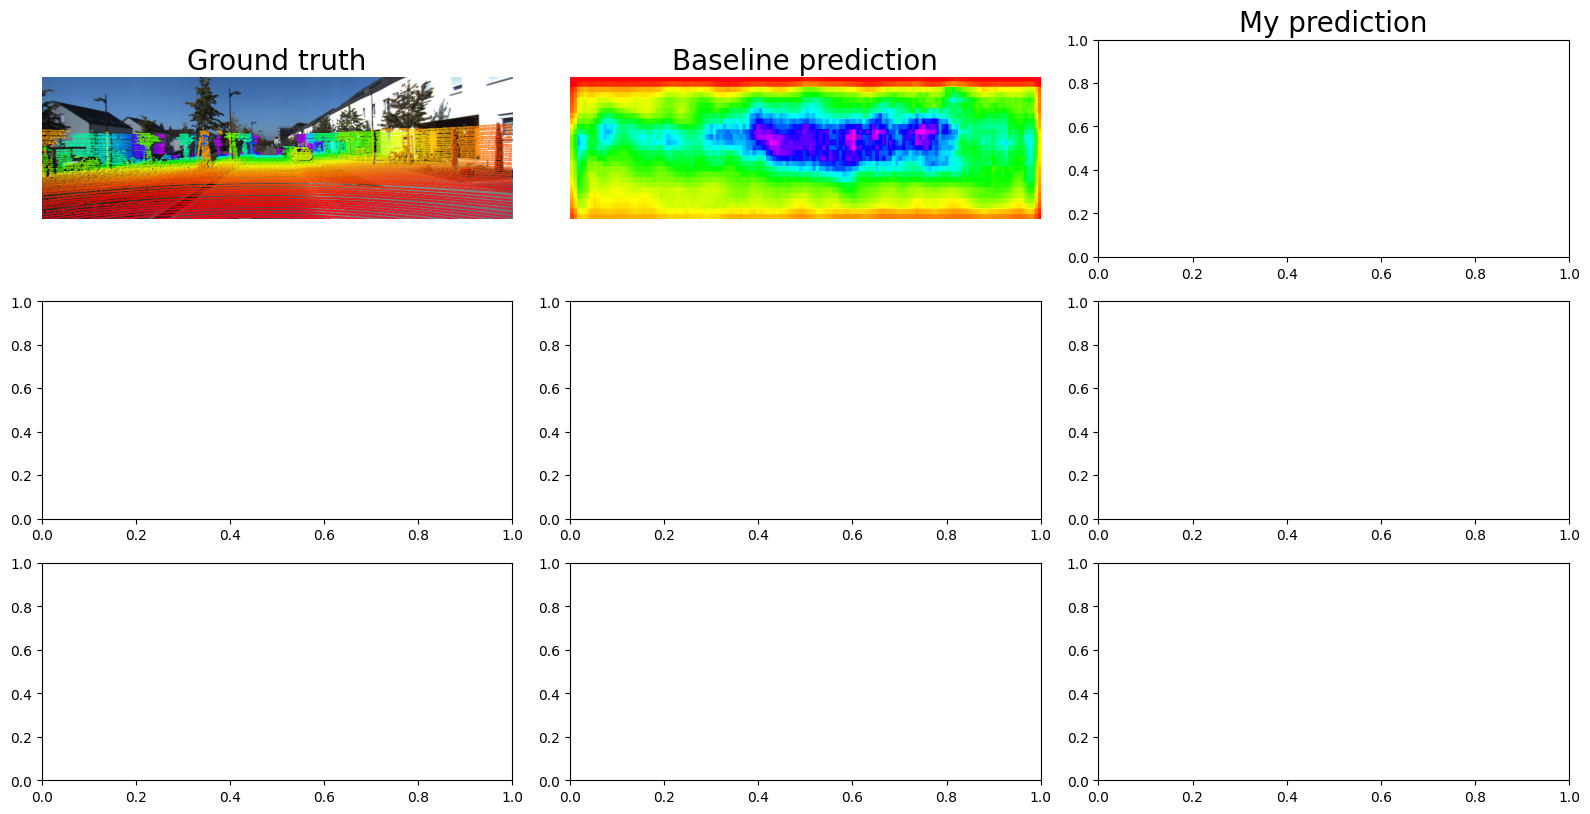

In [10]:
indices = random.choices(range(len(dataset)), k=6)
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
plt.tight_layout()

axes[0, 0].set_title("Ground truth", fontsize=20)
axes[0, 1].set_title("Baseline prediction", fontsize=20)
axes[0, 2].set_title("My prediction", fontsize=20)
for i in range(3):
    image, depth_map, camera_parameters = dataset[indices[i]]

    # To cuda
    image = image.to('cuda')
    for k in camera_parameters:
        camera_parameters[k] = camera_parameters[k].to('cuda')

    # to numpy
    np_image = image[0].cpu().permute(1, 2, 0).numpy()
    np_depth_map = depth_map[0, 0].cpu().numpy()

    # Valid pixels
    yy, xx = np.nonzero(np_depth_map)

    axes[i, 0].axis("off")
    axes[i, 0].imshow(np_image)
    axes[i, 0].scatter(xx, yy, c=np_depth_map[yy, xx], s=0.1, cmap="gist_rainbow")

    # EIGEN
    baseline_model.to('cuda')
    baseline_model.eval()
    with torch.no_grad():
        pred = baseline_model(image, camera_parameters)
    np_pred = pred[0, 0].cpu().numpy()
    axes[i, 1].axis("off")
    axes[i, 1].imshow(np_pred, cmap="gist_rainbow")
    #axes[i, 1].scatter(xx, yy, c=np_pred[yy, xx], s=0.1, cmap="gist_rainbow")
    baseline_model.to('cpu')

    # MY MODEL
    my_model.to('cuda')
    my_model.eval()
    pred = my_model(image, camera_parameters)
    np_pred = pred[0, 0].cpu().numpy()
    print(f"depth map ranges in {np_depth_map.min():.2f}, {np_depth_map.max():.2f}")
    print(f"predicted depth map ranges in {np_pred.min():.2f}, {np_pred.max():.2f}\n")

    axes[i, 2].axis("off")
    axes[i, 2].imshow(np_pred, cmap="gist_rainbow")
    #axes[i, 2].scatter(xx, yy, c=np_pred[yy, xx], s=0.1, cmap="gist_rainbow")
    my_model.to('cpu')
    
plt.show()